# Cylindrical Image Stitching
A code example using OpenCV in python to stitch together multiple images of a beverage can into a single planar image.

The images where captured via a camera situated in front of a rotary table (ie. a rotating platform). A can was placed upon the table about the center of rotation. Images were saved at a periodic interval during the can's rotation.

### References
* https://github.com/OpenStitching/stitching_tutorial/blob/master/Stitching%20Tutorial.ipynb
* https://stackoverflow.com/questions/12017790/warp-image-to-appear-in-cylindrical-projection

## To Do:
* Insert gif of rotary table
* Create a class to treat batches as objects with members:
    * Images
    * Features
    * Matches
    * ....

In [1]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np
from pathlib import Path

from stitching import Stitcher
from stitching.image_handler import ImageHandler
from stitching.feature_detector import FeatureDetector
from stitching.feature_matcher import FeatureMatcher
from stitching.subsetter import Subsetter
from stitching.camera_estimator import CameraEstimator
from stitching.camera_adjuster import CameraAdjuster
from stitching.camera_wave_corrector import WaveCorrector
from stitching.warper import Warper
from stitching.cropper import Cropper
from stitching.seam_finder import SeamFinder
from stitching.exposure_error_compensator import ExposureErrorCompensator
from stitching.blender import Blender

# Read in images from the imgs folder
can_imgs = [str(path.relative_to('.')) for path in Path('imgs').rglob(f'*{"_crop.png"}*')]
can_imgs.sort()

print("Number of images read: " + str(len(can_imgs)))

Number of images read: 11


## Lets try the built-in stitcher!

Stitching status: 0


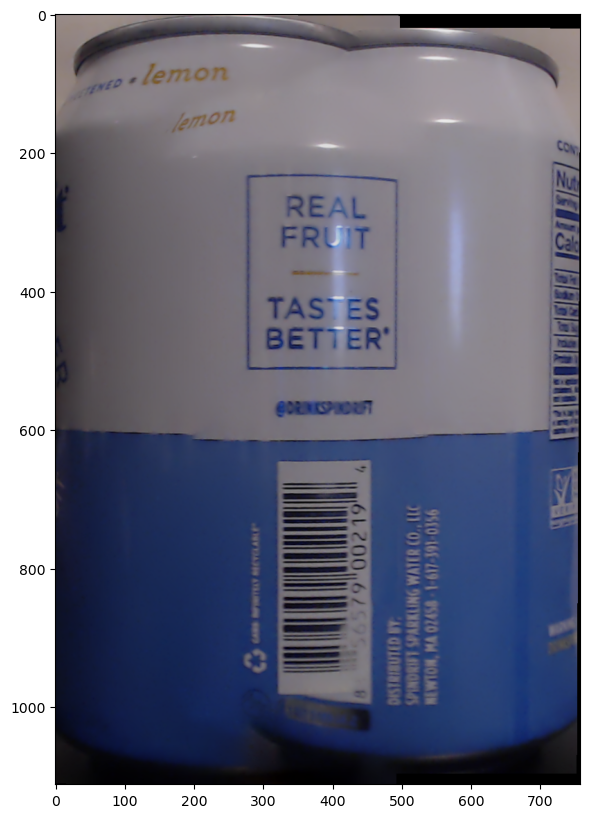

In [2]:
stitcher = cv.Stitcher_create()
img0 = cv.imread(can_imgs[0])
img1 = cv.imread(can_imgs[1])
img2 = cv.imread(can_imgs[2])
img3 = cv.imread(can_imgs[3])
img4 = cv.imread(can_imgs[4])
img5 = cv.imread(can_imgs[5])
img6 = cv.imread(can_imgs[6])
img7 = cv.imread(can_imgs[7])
img8 = cv.imread(can_imgs[8])
img9 = cv.imread(can_imgs[9])
img10 = cv.imread(can_imgs[10])
(status, stitched) = stitcher.stitch((img0,img1,img2,img3,img4,img5,img6,img7,img8,img9,img10))

print("Stitching status: " + str(status))

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(cv.cvtColor(stitched, cv.COLOR_BGR2RGB))
plt.show()

/home/shibley/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


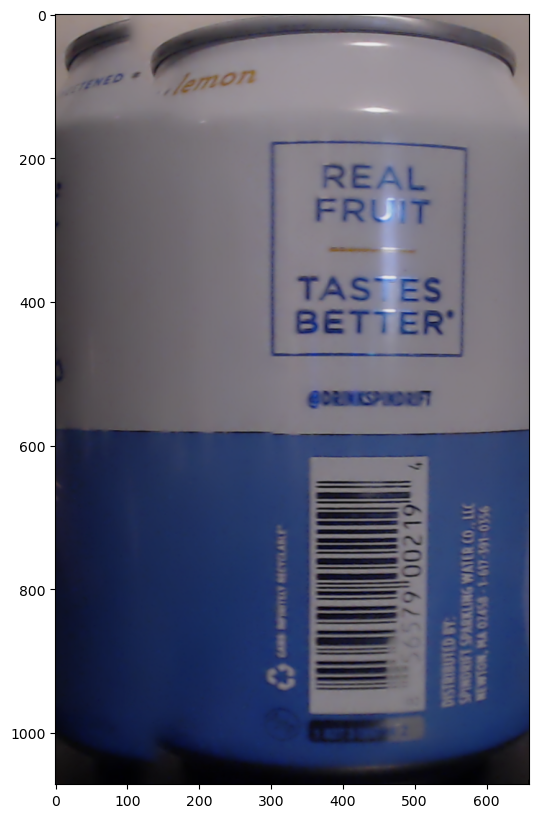

In [3]:
stitcher = Stitcher(detector="sift", confidence_threshold=0.7)
panorama = stitcher.stitch(can_imgs)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(cv.cvtColor(panorama, cv.COLOR_BGR2RGB))
plt.show()

## It seems not to stitch all the images together - so lets do it ourselves!

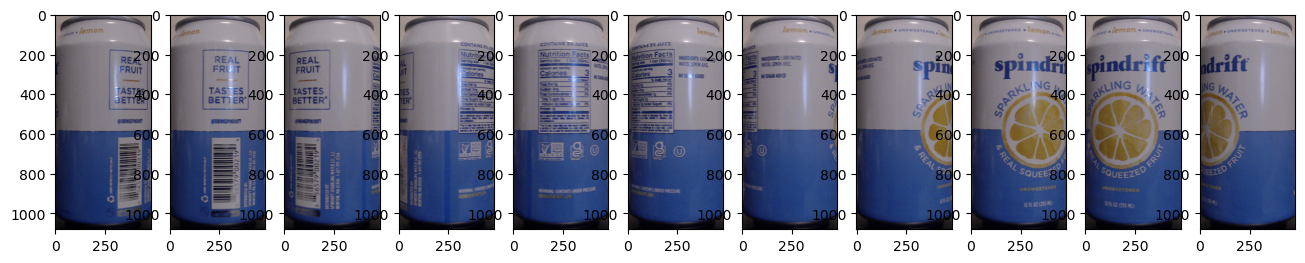

In [4]:
img_handler = ImageHandler()
img_handler.set_img_names(can_imgs)

orig_imgs = list(img_handler.resize_to_final_resolution())

# Generate a small image set to speed up operations
#low_imgs = list(img_handler.resize_to_low_resolution())

fig, axs = plt.subplots(1, len(orig_imgs), figsize=(16,4))
for col, img in enumerate(orig_imgs):
    axs[col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()



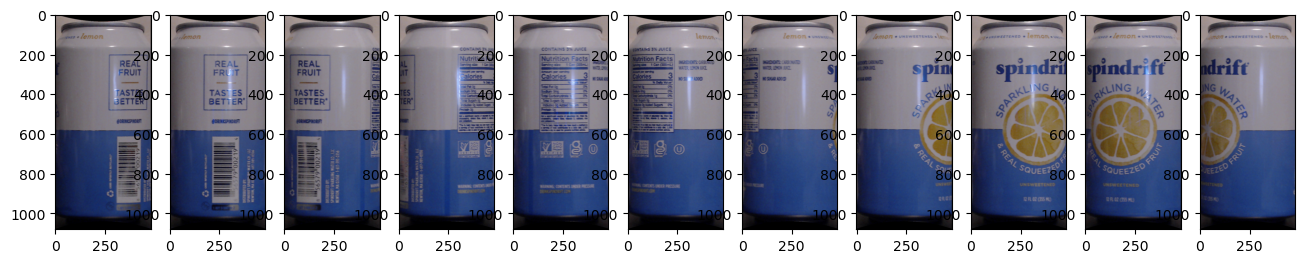

In [5]:

#
#  Cylindrical projection - derived from:
#  https://stackoverflow.com/questions/12017790/warp-image-to-appear-in-cylindrical-projection
#
#  We must invert the cylindrical projection to convert the cylindrical image back to a flat image
#  We do this by projecting each point on the cylindrical image to a point in a planar image
#
#  This code is unoptimized and slow. It is provided in the notebook for demonstration purposes.
#  It should be implemented in C++ for production use.
#  Took 13sec to run on 11 low resolution images (low_imgs)
#  Took 66sec to run on 11 high resolution images (orig_imgs)
# 
def convert_pt(point ,w: int,h: int):
    # center the point at 0,0
    pc = (point[0]-w/2,point[1]-h/2)

    # these are the free parameters (focal length & radius)
    f = float(w)*2.5 # this is the focal length (distance from pinhole to sensor)
    r = float(w)*.75 # this is the radius of the cylinder

    omega = float(w)/2
    z0 = f - np.sqrt(r*r-omega*omega)

    zc = (2*z0+np.sqrt(4*z0*z0-4*(pc[0]*pc[0]/(f*f)+1)*(z0*z0-r*r)))/(2*(pc[0]*pc[0]/(f*f)+1))
    final_point = ((pc[0]*zc/f)+float(w)/2,(pc[1]*zc/f)+float(h)/2)
    return final_point

warped_imgs = np.zeros((len(orig_imgs), orig_imgs[0].shape[0], orig_imgs[0].shape[1], 3), dtype=np.uint8)
for img, warped_img in zip(orig_imgs,warped_imgs):
    height = img.shape[0]
    width = img.shape[1]
    for y in range(height):
        for x in range(width):
            current_pos = convert_pt((x,y), width, height)

            top_left = (int(current_pos[0]),int(current_pos[1])); # top left because of integer rounding

            # make sure the point is actually inside the original image
            if top_left[0] < 0 or top_left[0] > width-2 or top_left[1] < 0 or top_left[1] > height-2:
                continue

            # bilinear interpolation
            dx = current_pos[0]-float(top_left[0])
            dy = current_pos[1]-float(top_left[1])

            weight_tl = (1.0 - dx) * (1.0 - dy)
            weight_tr = (dx)       * (1.0 - dy)
            weight_bl = (1.0 - dx) * (dy)
            weight_br = (dx)       * (dy)

            for channel in range(3):
                warped_img[y,x,channel] = np.uint8(weight_tl * float(img[top_left[1],top_left[0],channel]) +
                weight_tr * float(img[top_left[1],top_left[0]+1,channel]) +
                weight_bl * float(img[top_left[1]+1,top_left[0],channel]) +
                weight_br * float(img[top_left[1]+1,top_left[0]+1,channel]))

fig, axs = plt.subplots(1, len(warped_imgs), figsize=(16,4))
for col, img in enumerate(warped_imgs):
    axs[col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

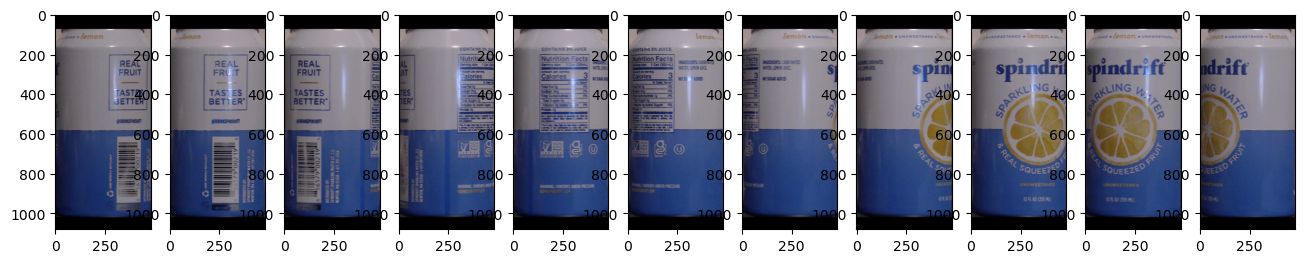

In [6]:
# Erase the top & bottom 5% of the images to remove the warped edges
plane_imgs = warped_imgs.copy()
plane_imgs[:, :int(0.07*warped_imgs.shape[1]), :, :] = 0
plane_imgs[:, -int(0.055*warped_imgs.shape[1]):, :, :] = 0

fig, axs = plt.subplots(1, len(plane_imgs), figsize=(16,4))
for col, img in enumerate(plane_imgs):
    axs[col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

## Now that the images have been unrolled a bit, shall we try the stitcher class gain?

Stitching status: 0


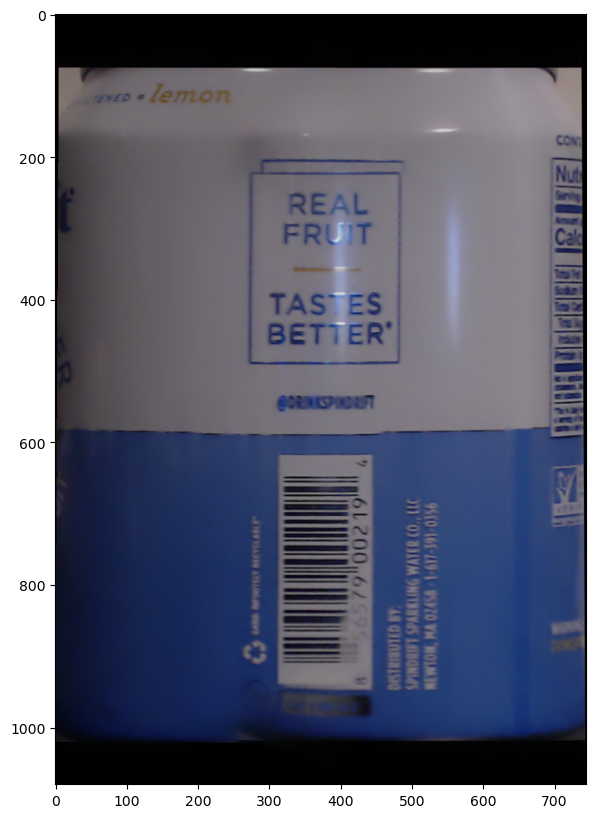

In [7]:
stitcher = cv.Stitcher_create()
(status, stitched) = stitcher.stitch(plane_imgs)

print("Stitching status: " + str(status))

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(cv.cvtColor(stitched, cv.COLOR_BGR2RGB))
plt.show()

### Maybe it helped a bit, but it's still not stitching all the images together - lets keep going!

I'm going to separate the images into batches. This gives the flexibility of treating all the images in a single large batch or in multiple smaller batches.

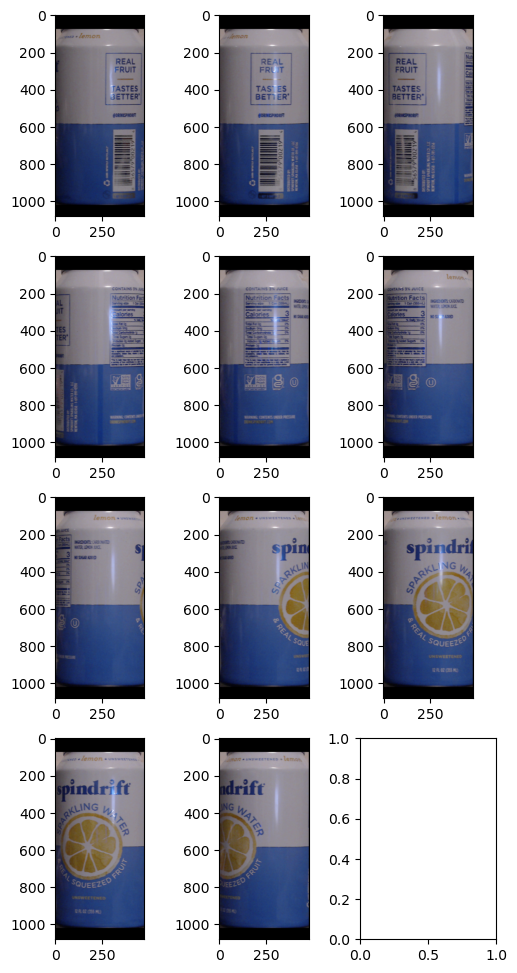

In [11]:
batch_size = 3
batch_overlap = 0
img_batches = []
for i in range(0, len(plane_imgs), batch_size - batch_overlap):
    img_batches.append(plane_imgs[i:i + batch_size])

# Display each image batch
fig, axs = plt.subplots(len(img_batches), batch_size, figsize=(2*batch_size,3*len(img_batches)))
for row, batch in enumerate(img_batches):
    for col, img in enumerate(batch):
        axs[row][col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()


Select features by which we can detect across the images

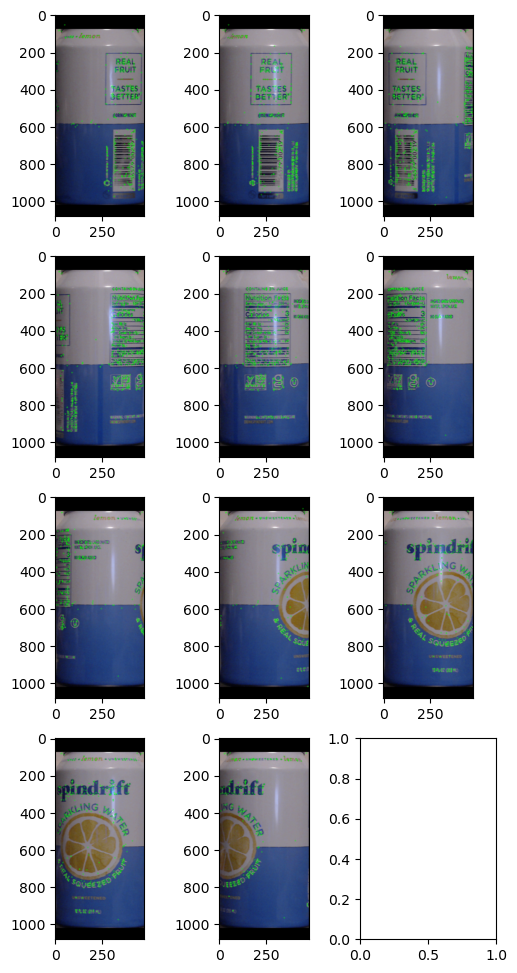

In [12]:
detector = FeatureDetector(detector='sift', nfeatures=1000)
keypoints_batches = []
features_batches = []
for imgs in img_batches:
    features = [detector.detect_features(img) for img in imgs]
    features_batches.append(features)
    keypoints_batches.append([detector.draw_keypoints(img, feature) for img, feature in zip(imgs, features)])

fig, axs = plt.subplots(len(keypoints_batches), batch_size, figsize=(2*batch_size,3*len(keypoints_batches)))
for row, batch in enumerate(keypoints_batches):
    for col, img in enumerate(batch):
        axs[row][col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

Match up the detected features across images according to the matching threshold (chosen as 0.93 here).

Number of images in batch: 3 and number of matches: 9 and number of features: 3
Number of images in batch: 3 and number of matches: 9 and number of features: 3
Number of images in batch: 3 and number of matches: 9 and number of features: 3
Number of images in batch: 2 and number of matches: 4 and number of features: 2


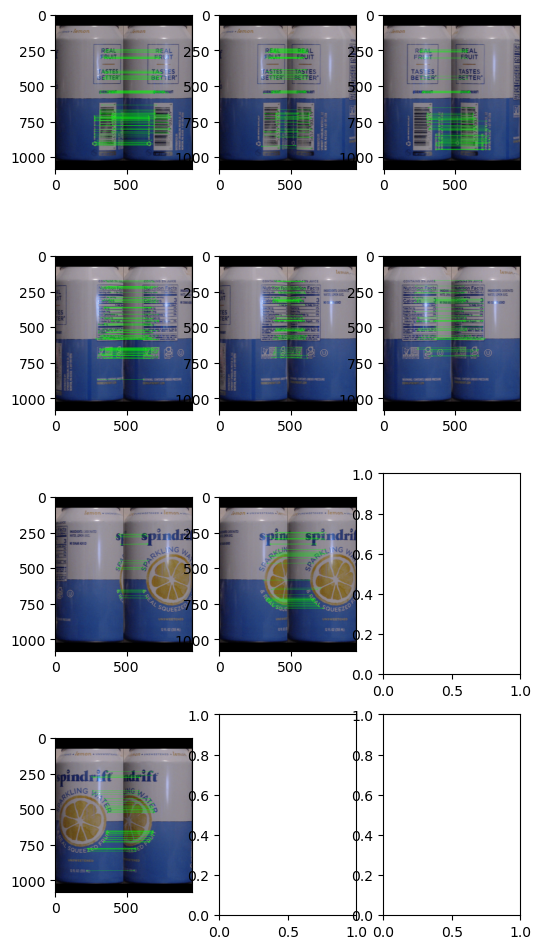

In [13]:
confidence_threshold = 0.93

matches_batches = []
subsetter_batches = []
for i in range(len(img_batches)):
#for imgs, features in zip(img_batches, features_batches):
    matcher = FeatureMatcher()
    subsetter = Subsetter(confidence_threshold=confidence_threshold)
    matches_batches.append(matcher.match_features(features_batches[i]))
    # Subset the images to only include matches above the confidence threshold
    #subsetter_batches.append(subsetter.get_matches_graph(img_handler.img_names, matches_batches[i]))
    indices = subsetter.get_indices_to_keep(features_batches[i], matches_batches[i])
    img_batches[i] = subsetter.subset_list(img_batches[i], indices)
    features_batches[i] = subsetter.subset_list(features_batches[i], indices)
    matches_batches[i] = subsetter.subset_matches(matches_batches[i], indices)
    print(f'Number of images in batch: {len(img_batches[i])} and number of matches: {len(matches_batches[i])} and number of features: {len(features_batches[i])}')

#for i, subsetter_batch in enumerate(subsetter_batches):
#    print(f'Batch {i}:')
#    print(subsetter_batch)

fig, axs = plt.subplots(len(matches_batches), 3, figsize=(2*3,3*len(matches_batches)))
for row, batch in enumerate(matches_batches):
    significant_matches = matcher.draw_matches_matrix(img_batches[row], features_batches[row], batch, conf_thresh=confidence_threshold, 
                                                   inliers=True, matchColor=(0, 255, 0))
    for col, img in enumerate([img for idx1, idx2, img in significant_matches]):
        axs[row][col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()
    

Final image sizes: [(480, 1080), (480, 1080), (480, 1080)]
Number of warped images: 3
Number of warped masks: 3


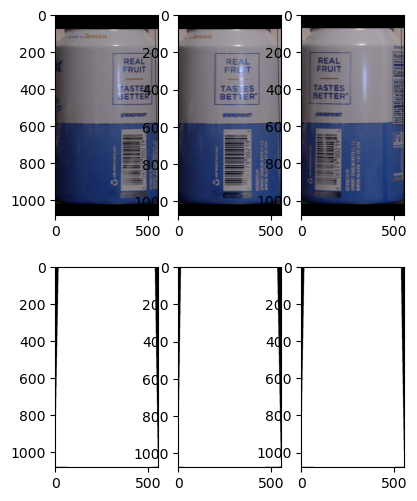

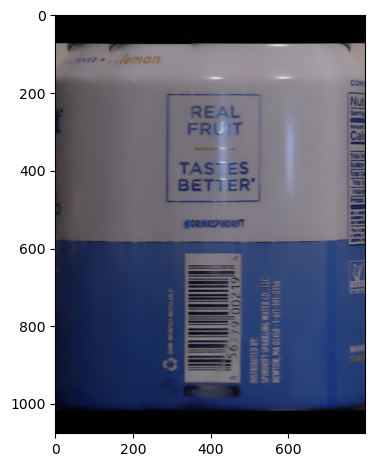

Final image sizes: [(480, 1080), (480, 1080), (480, 1080)]
Number of warped images: 3
Number of warped masks: 3


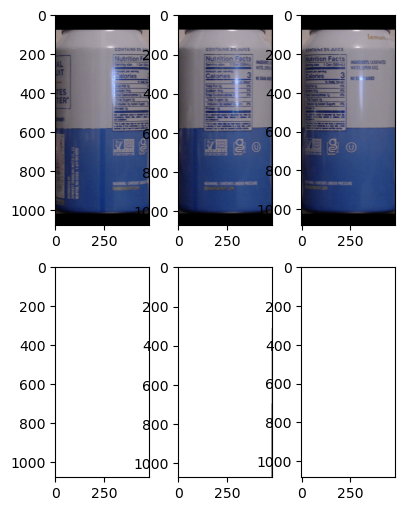

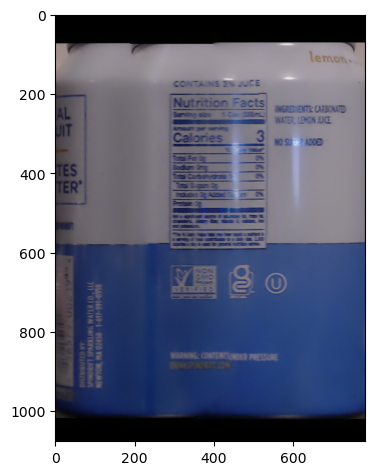

Final image sizes: [(480, 1080), (480, 1080), (480, 1080)]
Number of warped images: 3
Number of warped masks: 3


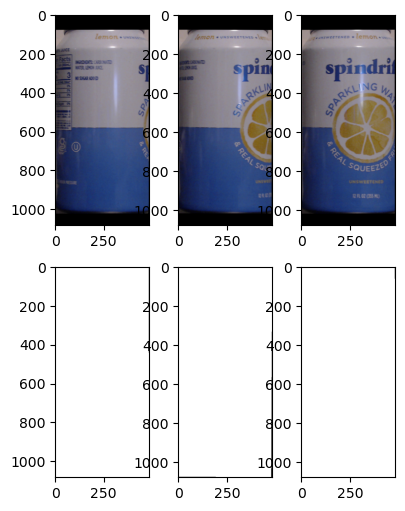

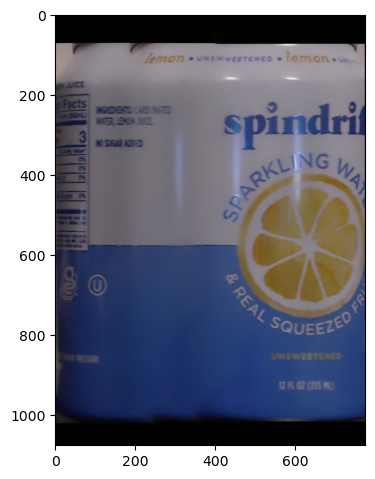

Final image sizes: [(480, 1080), (480, 1080)]
Number of warped images: 2
Number of warped masks: 2


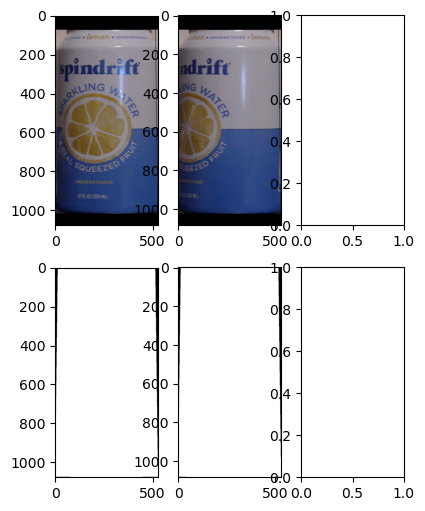

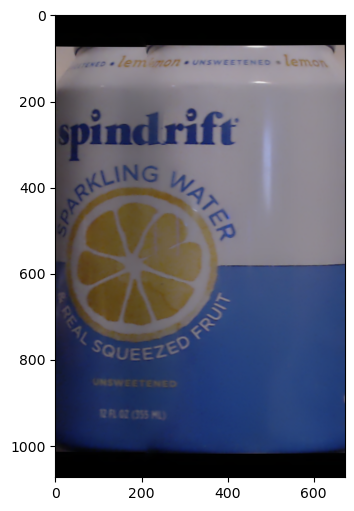

In [14]:
cameras_batches = []
panoramas = []
for i in range(len(img_batches)):
    camera_estimator = CameraEstimator()
    camera_adjuster = CameraAdjuster()
    wave_corrector = WaveCorrector()

    cameras = camera_estimator.estimate(features_batches[i], matches_batches[i])
    cameras = camera_adjuster.adjust(features_batches[i], matches_batches[i], cameras)
    cameras = wave_corrector.correct(cameras)
    cameras_batches.append(cameras)

    warper = Warper(warper_type='spherical')
    warper.set_scale(cameras)

    final_sizes = img_handler.get_final_img_sizes()[i*batch_size:((i+1)*batch_size)]

    warped_final_imgs = list(warper.warp_images(img_batches[i], cameras))
    warped_final_masks = list(warper.create_and_warp_masks(final_sizes, cameras))
    print(f'Final image sizes: {final_sizes}')
    print(f'Number of warped images: {len(warped_final_imgs)}')
    print(f'Number of warped masks: {len(warped_final_masks)}')
    final_corners, final_sizes = warper.warp_rois(final_sizes, cameras)
    
    fig, axs = plt.subplots(2, batch_size, figsize=(1.5*batch_size,3*2))
    for col, img in enumerate(warped_final_imgs):
        axs[0][col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    for col, img in enumerate(warped_final_masks):
        axs[1][col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

    # Crop images
    cropper = Cropper()
    mask = cropper.estimate_panorama_mask(warped_final_imgs, warped_final_masks, final_corners, final_sizes)
    lir = cropper.estimate_largest_interior_rectangle(mask)
    final_corners = cropper.get_zero_center_corners(final_corners)
    rectangles = cropper.get_rectangles(final_corners, final_sizes)
    overlap = cropper.get_overlap(rectangles[1], lir)
    intersection = cropper.get_intersection(rectangles[1], overlap)

    cropper.prepare(warped_final_imgs, warped_final_masks, final_corners, final_sizes)
    cropped_final_masks = list(cropper.crop_images(warped_final_masks))
    cropped_final_imgs = list(cropper.crop_images(warped_final_imgs))
    final_corners, final_sizes = cropper.crop_rois(final_corners, final_sizes)

    # Compensate for exposure errors
    compensator = ExposureErrorCompensator()

    compensator.feed(final_corners, cropped_final_imgs, cropped_final_masks)

    compensated_imgs = [compensator.apply(idx, corner, img, mask) 
                        for idx, (img, mask, corner) 
                        in enumerate(zip(cropped_final_imgs, cropped_final_masks, final_corners))]
    
    # Find seams
    seam_finder = SeamFinder()

    seam_masks = seam_finder.find(cropped_final_imgs, final_corners, cropped_final_masks)
    seam_masks = [seam_finder.resize(seam_mask, mask) for seam_mask, mask in zip(seam_masks, cropped_final_masks)]

    seam_masks_plots = [SeamFinder.draw_seam_mask(img, seam_mask) for img, seam_mask in zip(cropped_final_imgs, seam_masks)]
    #plot_images(seam_masks_plots, (15,10))

    # Blend images
    blender = Blender()
    blender.prepare(final_corners, final_sizes)
    for img, mask, corner in zip(compensated_imgs, seam_masks, final_corners):
        blender.feed(img, mask, corner)
    panorama, _ = blender.blend()
    panoramas.append(panorama)

    # Plot the final panorama
    fig, ax = plt.subplots(figsize=(4,6))
    ax.imshow(cv.cvtColor(panorama, cv.COLOR_BGR2RGB))
    plt.show()
